## Notebook to align un-merged cubes

both for the intermediate cubes, the total observation cubes, and then for the final cube, add a wcs

In [15]:
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy.wcs import WCS, wcslint
from astropy.coordinates import SkyCoord

import matplotlib as mpl
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import glob

In [3]:
def load_files(path):
    path_list = sorted(glob.glob(path))
    
    fl_list = []
    
    for flname in path_list:
        fl = fits.open(flname)        
        fl_list.append(fl)

    return fl_list, path_list

def move_wcs(dx, dy, wcs): #from Liza/Yuanze
    """Given (dx, dy) in px, translate the image horizontally/vertically by changing the
    coordinate of the reference pixel"""
    
    # Figure out the change in the reference coordinates for given (dy, dx)
    pc      = wcs.wcs.pc
    d_crval = pc.dot(np.array([dx, dy])) 
    
    # Change the reference pixel's ra, dec 
    new_wcs       = wcs.deepcopy()
    new_crpix     = wcs.wcs.crpix + d_crval
    new_wcs.wcs.crpix = new_crpix
    return new_wcs

In [4]:
def extract_channel_maps(fl_list, rest_wave=2.1213*u.micron, width=500*u.km/u.s):
    #return channel maps for each file in list with wcs
    
    map_list = []
    wcs_list = []
    
    z = 0.007214
    line_wave = rest_wave * (1+z)
    wave_to_vel = u.doppler_optical(line_wave)
    
    for fl in fl_list:
        cube = fl[1].data
        h0 = fl[0].header
        h1 = fl[1].header
        
        pixscale = h1['PIXSCALE']*u.arcsecond #arcsec/pix
        pixscale = (pixscale.to(u.degree)).value
        wcs_dict = {
        'CTYPE1': 'WAVE    ', 'CUNIT1': 'Angstrom', 'CDELT1': h1['CD3_3'], 'CRPIX1': h1['CRPIX3'], 'CRVAL1': h1['CRVAL3'], 'NAXIS1': h1['NAXIS3'],
        'CTYPE2': 'RA---TAN', 'CUNIT2': 'deg', 'CDELT2': pixscale, 'CRPIX2': h0['CRPIX1'], 'CRVAL2': h0['CRVAL1'], 'NAXIS2': h1['NAXIS2'],
        'CTYPE3': 'DEC--TAN', 'CUNIT3': 'deg', 'CDELT3': pixscale, 'CRPIX3': h0['CRPIX2'], 'CRVAL3': h0['CRVAL2'], 'NAXIS3': h1['NAXIS1']}
        wcs = WCS(wcs_dict)
        
        start = h1['CRVAL3'] - (h1['CRPIX3'] * h1['CD3_3'])
        end = start + ((h1['NAXIS3']-1) * h1['CD3_3'])
        wave_array = np.arange(start, end, h1['CD3_3']) * u.Angstrom
        
        vel_array = wave_array.to(u.km/u.s, equivalencies=wave_to_vel)
        lower_ind = np.searchsorted(vel_array, -width/2)
        upper_ind = np.searchsorted(vel_array, width/2)
        
        slab = cube[lower_ind:upper_ind, :, :]
        
        chan_map = np.nansum(slab, axis=0)
        
        map_list.append(chan_map)
        wcs_list.append(wcs.celestial)
    
    return map_list, wcs_list
        

In [4]:
def edit_file_wcs(path_list, x_shift, y_shift):
    
    for i, path_name in enumerate(path_list):
        fl = fits.open(path_name)
        crpix1 = fl[0].header['CRPIX1']
        fl[0].header['CRPIX1'] = crpix1 - x_shift[i]
        
        crpix2 = fl[0].header['CRPIX2']
        fl[0].header['CRPIX2'] = crpix2 - y_shift[i]
        
        flname = path_name.split('/')[-1]
        new_flname = 'shift_'+flname
        new_path = '/'.join(path_name.split('/')[0:-1])
        full_new_path = new_path + '/' + new_flname
        
        fl.writeto(full_new_path, overwrite=True)

## Working on Obs57 cubes

647 664
647 664
647 664
647 664


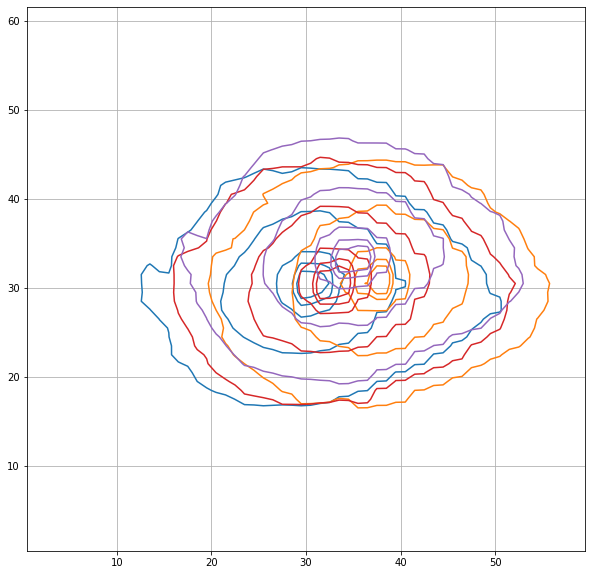

In [9]:
##Obs 57 cubes - initial plot with given WCS

file_list_57, path_list_57 = load_files('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/original_reduction/intermediate_products/obs57/fact*.fits')

chan_list, wcs_list = extract_channel_maps(file_list_57)

perc_lvls = np.array([0.3,0.5,0.8,0.9,0.95])
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    wcs = wcs_list[i]
        
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], 
               origin='lower')

ax.grid()
    


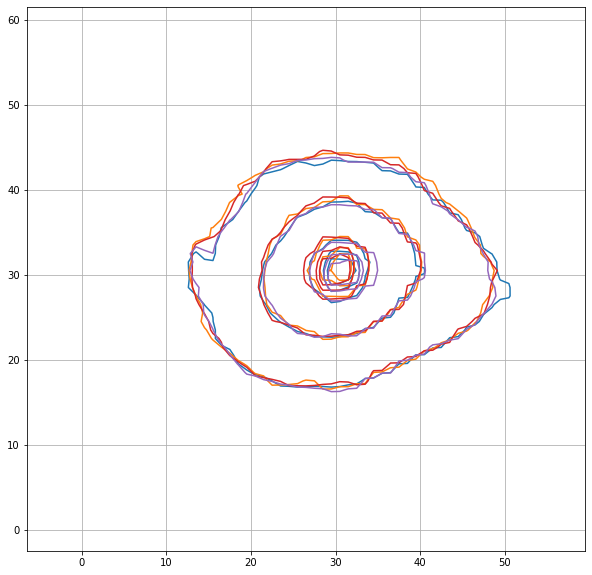

In [28]:
shift_list = [
    [0,0],
    [-7,0],
    [-3,0],
    [-4,-3]
]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plot_list = [0, 1,2,3]

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    dx, dy = shift_list[i]
    transform = mpl.transforms.Affine2D().translate(dx, dy)
    
    if i not in plot_list:
        continue
    
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], transform=transform + ax.transData, origin='lower')

ax.grid()

# Obs 49 cubes

648 665
648 665
648 665
648 665


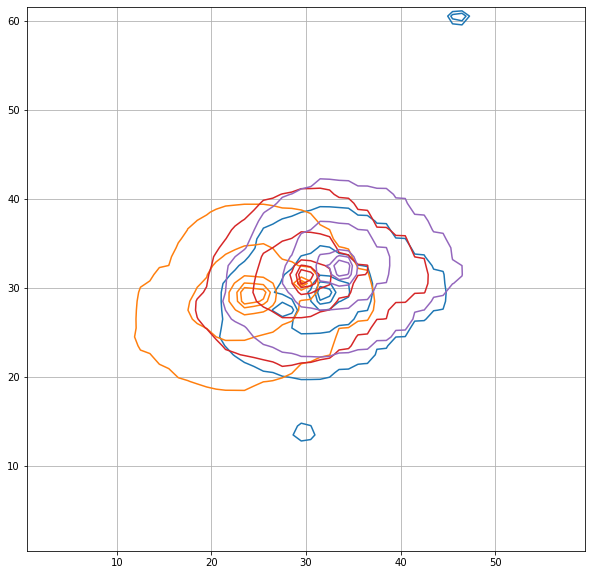

In [29]:
##Obs 49 cubes - initial plot with given WCS

file_list_49, path_list_49 = load_files('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/original_reduction/intermediate_products/obs49/fact*.fits')
chan_list, wcs_list = extract_channel_maps(file_list_49)

perc_lvls = np.array([0.3,0.5,0.8,0.9,0.95])
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    wcs = wcs_list[i]
        
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], origin='lower')

ax.grid()
    


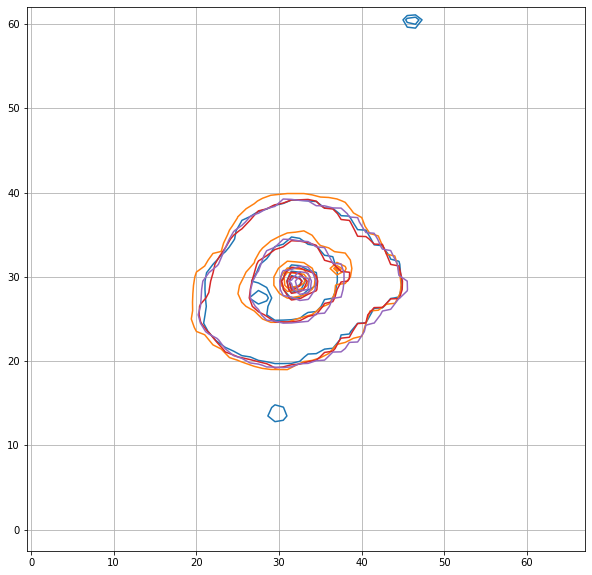

In [42]:
shift_list = [
    [0,0],
    [7.5,0.5],
    [2,-2],
    [-1,-3]
]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plot_list = [0,1,2,3]

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    dx, dy = shift_list[i]
    transform = mpl.transforms.Affine2D().translate(dx, dy)
    
    if i not in plot_list:
        continue
    
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], transform=transform + ax.transData, origin='lower')

ax.grid()

# Obs 65

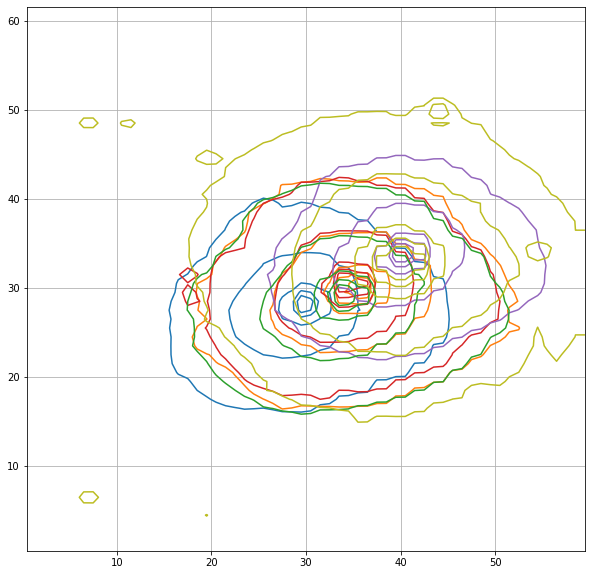

In [45]:
##Obs 65 cubes - initial plot with given WCS

file_list_65, path_list_65 = load_files('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/original_reduction/intermediate_products/obs65/fact*.fits')
chan_list, wcs_list = extract_channel_maps(file_list_65, width=500*u.km/u.s)

perc_lvls = np.array([0.3,0.5,0.8,0.9,0.95])
colors = ['tab:blue', 'tab:orange', 'tab:red', 'tab:purple', 'tab:green', 'tab:olive']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    wcs = wcs_list[i]
        
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], origin='lower')

ax.grid()
    


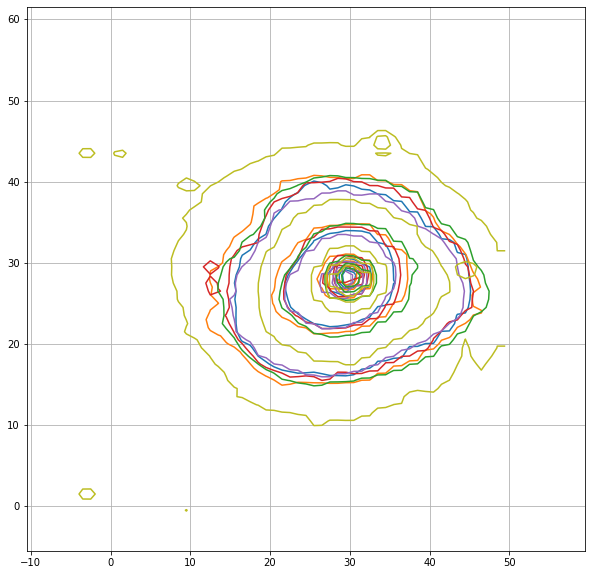

In [74]:
shift_list = [
    [0,0],
    [-6,-1.5], #[-6,-2] if only integer
    [-5,-2],
    [-11,-6],
    [-4,-1],
    [-10,-5]
]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plot_list = [0,1,2,3,4,5]

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    dx, dy = shift_list[i]
    transform = mpl.transforms.Affine2D().translate(dx, dy)
    
    if i not in plot_list:
        continue
    
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], transform=transform + ax.transData, origin='lower')

ax.grid()

# Final merge

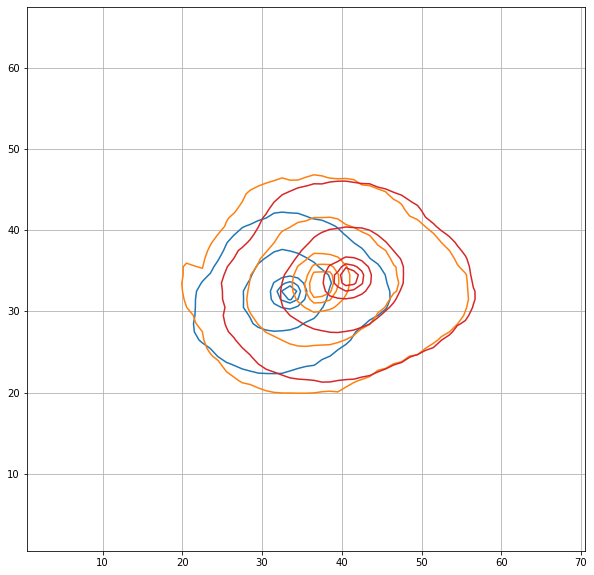

In [75]:
## observation cubes

file_list_fin, path_list_fin = load_files('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/man_offset2/*obs*.fits')

chan_list, wcs_list = extract_channel_maps(file_list_fin)

perc_lvls = np.array([0.3,0.5,0.8,0.9,0.95])
colors = ['tab:blue', 'tab:orange', 'tab:red']

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    wcs = wcs_list[i]
        
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], 
               origin='lower')

ax.grid()
    


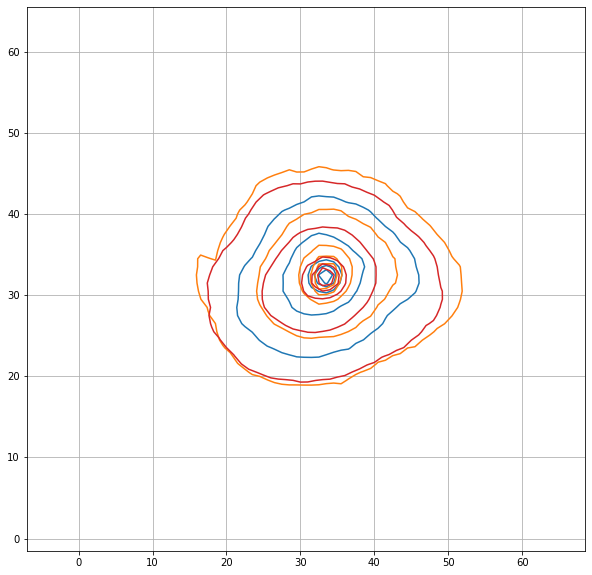

In [83]:
shift_list = [
    [0,0],
    [-4,-1],
    [-7.5,-2],
]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plot_list = [0,1,2]

for i in range(len(chan_list)):
    chan_map = chan_list[i]
    dx, dy = shift_list[i]
    transform = mpl.transforms.Affine2D().translate(dx, dy)
    
    if i not in plot_list:
        continue
    
    cont_lvls = perc_lvls * np.nanmax(chan_map)
    ax.contour(chan_map, levels=cont_lvls, colors=colors[i], transform=transform + ax.transData, origin='lower')

ax.grid()

# Add WCS info to final cube

In [58]:
final_path = '/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/reduced_cubes/man_offset2/TOTAL_mergedK.fits'
fin_fl = fits.open(final_path)

print(fin_fl[1].data.shape)

h0 = fin_fl[0].header
h1 = fin_fl[1].header

pixscale = h1['PIXSCALE']*u.arcsecond #arcsec/pix
pixscale = (pixscale.to(u.degree)).value
wcs_dict = {
'CTYPE3': 'WAVE    ', 'CUNIT3': 'Angstrom', 'CDELT3': h1['CD3_3'], 'CRPIX3': h1['CRPIX3'], 'CRVAL3': h1['CRVAL3'], 'NAXIS3': h1['NAXIS3'],
'CTYPE1': 'RA---TAN', 'CUNIT1': 'deg', 'CDELT1': pixscale, 'CRPIX1': h0['CRPIX1'], 'CRVAL1': h0['CRVAL1'], 'NAXIS1': h1['NAXIS2'],
'CTYPE2': 'DEC--TAN', 'CUNIT2': 'deg', 'CDELT2': pixscale, 'CRPIX2': h0['CRPIX2'], 'CRVAL2': h0['CRVAL2'], 'NAXIS2': h1['NAXIS1'], 'RADESYS': 'FK5'}

wcs = WCS(wcs_dict)

speccube = SpectralCube(data=fin_fl[1].data, wcs=wcs)
cube_trim = speccube[60:2020,:,:]

newhead = cube_trim.wcs.to_header()

for card in newhead.cards:
    fin_fl[1].header[card[0]] = card[1]
    print(card[0], card[1])
    
#naxis1 = h1['NAXIS3']
#naxis2 = h1['NAXIS2']
#naxis3 = h1['NAXIS1']
#fin_fl[1].header['NAXIS1'] = naxis1
#fin_fl[1].header['NAXIS2'] = naxis2
#fin_fl[1].header['NAXIS3'] = naxis3

fin_fl[1].header['CD1_1'] = newhead['CDELT1']
fin_fl[1].header['CD2_2'] = newhead['CDELT2']
fin_fl[1].header['CD3_3'] = newhead['CDELT3']

fin_fl[1].data = cube_trim

fin_fl.writeto('/Users/jotter/highres_PSBs/ngc1266_data/NIFS_data/NGC1266_NIFS_final_trim.fits', overwrite=True)
fin_fl.close()

(2042, 68, 79)
WCSAXES 3
CRPIX1 14.999944
CRPIX2 34.000178
CRPIX3 -57.0
CDELT1 1.1944444444444e-05
CDELT2 1.1944444444444e-05
CDELT3 2.1325941085815e-10
CUNIT1 deg
CUNIT2 deg
CUNIT3 m
CTYPE1 RA---TAN
CTYPE2 DEC--TAN
CTYPE3 WAVE
CRVAL1 49.003394
CRVAL2 -2.427118
CRVAL3 1.9969009765625e-06
LONPOLE 180.0
LATPOLE -2.427118
MJDREF 0.0
RADESYS FK5
EQUINOX 2000.0


In [54]:
WCS(fin_fl[1].header)

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 49.003394  -2.427118  1.9969009765625e-06  
CRPIX : 14.999944  34.000178  3.0  
CD1_1 CD1_2 CD1_3  : 1.1944444444444e-05  0.0  0.0  
CD2_1 CD2_2 CD2_3  : 0.0  1.1944444444444e-05  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  2.1325941085815e-10  
NAXIS : 79  68  2042

In [52]:
fin_fl[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    3 / Number of axes                                 
NAXIS1  =                   79 / Axis length                                    
NAXIS2  =                   68 / Axis length                                    
NAXIS3  =                 2042 / Axis length                                    
PCOUNT  =                    0 / No 'random' parameters                         
GCOUNT  =                    1 / Only one group                                 
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
OBJECT  = 'NGC1266 '           / Name of the object observed                    
DATE    = '2023-06-28T14:51:59' / Date FITS file was generated                  
IRAF-TLM= '2023-06-28T14:51:44' / Time of last modification                     
NFPAD   = '2023-06-15T19:15:

In [38]:
h1['CRPIX2']

14.999944